In [1]:
import torch, math
import torch.nn as nn # all neural network modules, nn.Linear, nn.Conv2d, BatchNorm, loss functions
import torch.optim as optim # all optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # all functions that dont have any parameters eg: activations like relu
from torch.utils.data import Dataset, DataLoader # gives easier dataset management and creates mini batches
import torchvision.datasets as datasets # standard public datasets
import torchvision.transforms as transforms # transforms on dataset
import numpy as np

# Hyperparameters

In [20]:
BATCH_SIZE = 8
EPOCHS = 50
LR = 0.001
INPUT_CHANNELS = 3
NUM_CLASSES = 10
RESIZE_WIDTH = 224
RESIZE_HEIGHT = 224

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Apply data transforms for image classification

In [3]:
# 1. Get mean and std deviation of my dataset
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(),
                                download=True)
loader = DataLoader(dataset=test_dataset, batch_size=64)
def get_mean_std(loader):
    '''Calculate mean for input channels and std dev for input channels'''
    # std_dev = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        ''' We have an input that is (N, C, H, W) where N is the number of examples in our batch,
        C the number of channels and H, W the height and width. 
        We want to have the mean (of each channel) across all examples, all the height pixels and width pixels. 
        This is why I specify dim=[0,2,3], because we want to reduce all the other dimensions 
        except for the channels. '''
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = torch.sqrt((channels_squared_sum/num_batches) - mean**2)
    return mean.numpy(), std.numpy()

MEAN, STD = get_mean_std(loader)
print(MEAN, STD)

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(RESIZE_WIDTH,RESIZE_HEIGHT), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

Files already downloaded and verified
[0.4941781  0.4851347  0.45040762] [0.24667414 0.24295948 0.2616299 ]


# Load the dataset

In [4]:
# load the cifar 10 dataset
train_dataset = datasets.CIFAR10(root="dataset/", train=True, 
                                 transform=transform,
                                  download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, 
                                transform=transform,
                                download=True)

# Instantiate loader objects to facilitate processing
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Creating our CNN class extending from nn.module
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        ''' define the layers of the network '''
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32,
                               kernel_size=(3,3)) # 32 x 222 x 222
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels, out_channels=32,
                               kernel_size=(3,3)) # 32 x 220 x 220
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # 32 x 110 x 110

        self.conv3 = nn.Conv2d(in_channels=self.conv2.out_channels, out_channels=64,
                               kernel_size=(3,3)) # 64 x 108 x 108
        self.conv4 = nn.Conv2d(in_channels=self.conv3.out_channels, out_channels=64,
                               kernel_size=(3,3)) # 64 x 106 x 106
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # 64 x 53 x 53

        self.fc1 = nn.Linear(in_features=self.conv4.out_channels * 53 * 53,
                             out_features= 53 * 53)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features, out_features=num_classes)
        return
    
    def forward(self, x):
        ''' progresses the data across the layers '''
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.pool1(out)

        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.pool2(out)

        # need to flatten conv features from NxCxHxW to Nxfeatures before sending to fc block
        out = out.reshape(out.shape[0], -1) # same as out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out) # N x num_classes
        return out

# Testing the CNN on dummy data

In [21]:
model = CNN(input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES).to(device)
dummy_data = torch.rand(size=(BATCH_SIZE, INPUT_CHANNELS, RESIZE_HEIGHT, RESIZE_WIDTH)).to(device)
model(dummy_data).shape # BATCH_SIZE x NUM_CLASSES

torch.Size([8, 10])

# Load the loss and optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

# Train Pipeline

In [23]:
def train():
    model.train()
    avg_train_loss = []
    for epoch in range(EPOCHS):
        train_loss = 0.0
        for data, target in train_loader:
            # push data to device
            data, target = data.to(device), target.to(device)

            # Forward propagation
            logits = model(data)

            # Calculate loss
            loss = criterion(logits, target)
            train_loss += loss.item()

            # Clean the previous gradients
            optimizer.zero_grad()

            # Backpropagation from loss, calculate new gradients
            loss.backward()

            # Update weights by stepping in direction of min gradients
            optimizer.step()
        
        avg_train_loss.append(train_loss/BATCH_SIZE)
        scheduler.step(train_loss/BATCH_SIZE)
        if epoch % 2 ==0:
            print(f"Epoch : {epoch},  Train Loss: {train_loss:.2f}")

    return avg_train_loss

In [24]:
def predict():
    model.eval()
    correct_samples, total_samples, avg_test_loss = 0, 0, 0
    n_iterations = math.ceil(len(test_dataset)/BATCH_SIZE)
    with torch.no_grad():
        for data, target in test_loader:
            # push data to device
            data, target = data.to(device), target.to(device)

            # Forward propagation
            logits = model(data)

            # Calculate loss
            loss = criterion(logits, target)
            avg_test_loss += loss.item()

            # Get the class
            pred = torch.argmax(input=torch.softmax(data), dim=1)
            correct_samples += (target == pred).sum()
            total_samples += target.shape[1]
    
    avg_test_loss /= n_iterations

    accuracy = correct_samples / total_samples

    return avg_test_loss, accuracy
    


# Dummy test- Overfit on a small sample of train data to check if the model works as intended

In [12]:
data, target = next(iter(train_loader))
epoch_train_loss =[]

In [17]:
# overfit on 1 batch of training data

model.train()

for epoch in range(100):
    # push data to device
    data, target = data.to(device), target.to(device)

    # Forward propagation
    logits = model(data)

    # Calculate loss
    loss = criterion(logits, target)
    train_loss = loss.item()

    # Clean the previous gradients
    optimizer.zero_grad()

    # Backpropagation from loss, calculate new gradients
    loss.backward()

    # Update weights by stepping in direction of min gradients
    optimizer.step()
    scheduler.step(loss)
    if epoch % 5 ==0:
        print(train_loss)
    epoch_train_loss.append(train_loss)

1.9967415028077085e-06
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
7.748580514999048e-07
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
0.0
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
0.0


KeyboardInterrupt: 

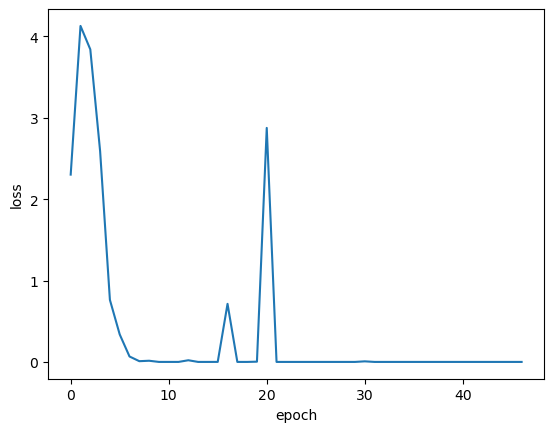

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(len(epoch_train_loss)), epoch_train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Reset the weights learned from the overfitting experiment and perform actual train and prediction

In [25]:
avg_train_loss = train()
avg_test_loss, accuracy = predict()


KeyboardInterrupt: 